In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

# Homework №1

    In this homework you will need to implement the following stuff:
        1) Discrete Fourier Transform
        2) Fast Fourier Transform
        3) Compare by performance
        4) Short-time Fourier Transform based on (2) and hann window function
        5) MelScale
        6) Digit classification based on you melspectrograms
        
    Note:
        You should test your implementation with torchaudio functions
        (e.g. torch.allclose(torchaudio.transforms.Spectrogram.__call__, your_function))

### Main rules
    1) All operations must be implemented with pytorch (don't use numpy)
    2) Everything should support batch input
    3) No cycles, only matrix multiplications
    4) Clean and clear code 

In [3]:
import torch
import torchaudio

# Discrete Fourier Transform (1 pts)

In [4]:
import numpy as np
from math import pi, sqrt

import numpy as np
def DFT_matrix_np(N):
    i, j = np.meshgrid(np.arange(N), np.arange(N))
    omega = np.exp( - 2 * pi * 1J / N )
    W = np.power( omega, i * j ) / sqrt(N)
    return W

def DFT_matrix(N):
    i, j = torch.meshgrid(torch.arange(N), torch.arange(N))
    omega = torch.exp(torch.tensor(- 2 * pi * 1J / N ))
    W = (omega ** (i * j )) / N
    return W


def DFT(x):
    return torch.mv(
        DFT_matrix(x.flatten().size()[0]), 
        x.type(torch.complex64).flatten()
    ).abs()


In [5]:
def DFT_matrix(N):
    i, j = torch.meshgrid(torch.arange(N), torch.arange(N))
    omega = - 2 * pi / N  * (i * j)
    W1 = torch.cos(omega)
    W2 = torch.sin(omega)
    return W1, W2


def DFT(x):
    N = x.size()[1]
    W1, W2 =  DFT_matrix(N)
    return ((x @ W1 + 1J * (x @ W2)))

### Sanity Check

In [8]:
wav_file = 'audio.wav'
wav, sr = torchaudio.load(wav_file)

In [9]:
from IPython.display import Audio

In [10]:
Audio(wav, rate=sr)

In [11]:
N = 16
a = torch.fft(
    torch.stack((wav[:, :N].flatten(), torch.zeros(N))).T, 
    1
).norm(dim=1)


In [12]:
b = DFT(wav[:, :N]).abs()

In [13]:
torch.allclose(a, b, atol=1e-6)

True

# Fast Fourier Transform (3pts)

    A common task for machine learning engineer is to take an paper and implement it.
    So, just do it!
[Tap on me](http://www.robots.ox.ac.uk/~sjrob/Teaching/SP/l7.pdf)
    

In [14]:
from collections import deque

In [15]:
B = torch.stack((
    torch.arange(6).view(2, -1),
    torch.arange(6).view(2, -1),
), dim=0)

A = torch.randint(0, 10, (2, 2))\

print(A @ B)
print(A, B)

tensor([[[24, 37, 50],
         [15, 28, 41]],

        [[24, 37, 50],
         [15, 28, 41]]])
tensor([[5, 8],
        [8, 5]]) tensor([[[0, 1, 2],
         [3, 4, 5]],

        [[0, 1, 2],
         [3, 4, 5]]])


In [16]:
def _FFT(x):
    N = x.size()[0]
    if N == 2:
        return DFT(x)
    else:
        even, odd = _FFT(x[::2]), _FFT(x[1::2])
        terms = torch.exp(-2j * pi * torch.arange(N) / N)
        return torch.cat((even + terms[:int(N/2)] * odd,
                               even + terms[int(N/2):] * odd))
    
def _FFT_v(x):
    batch_size, window_num, N = x.shape
    N_min = min(N, 2)
    
    n = torch.arange(N_min)
    k = n[:, None]
    omega = -2 * pi * n * k / N_min
    M_1 = torch.cos(omega)
    M_2 = torch.sin(omega)
    x = x.view((batch_size, window_num, N_min, -1))
    X = M_1 @ x + 1j * (M_2 @ x)
    while X.shape[2] < N:
            X_even = X[:, :, :,  :int(X.shape[3] / 2)]
            X_odd = X[:, :, :, int(X.shape[3] / 2):]
            terms = torch.exp(-1j * pi * torch.arange(X.shape[2])
                            / X.shape[2])[:, None]
            X = torch.cat([X_even + terms * X_odd,
                           X_even - terms * X_odd], dim=2)
    return X.squeeze(dim=3)
        

def FFT(x):
    d0, d1, d2 = x.shape
    n = np.ceil(np.log2(d2))
    if 2 ** n - d2 != 0:
        _x = torch.cat((x, torch.zeros(d0, d1, int(2 ** n - d2))))
    else: 
        _x = x
    
    return _FFT_v(_x)
        

In [17]:
c = FFT(wav[:, :N].unsqueeze(dim=0)).abs()

In [18]:
c = FFT(wav[:, :N].unsqueeze(dim=0)).abs()
torch.allclose(a, c[0][0], atol=1e-6)

True

# A comparison of the performance (1e-7 pts)
    Do pretty images :)

In [19]:
import timeit
from tqdm.auto import tqdm

In [20]:
N = 1000

In [ ]:
fft_bm = [
    timeit.timeit(lambda: FFT(wav[:, :n]), number=1000)/ N 
    for n in tqdm(2 ** np.arange(2, 13))
]

In [449]:
dft_bm = [
    timeit.timeit(lambda: DFT(wav[:, :n]), number=1000) / N 
    for n in tqdm( 2 ** np.arange(2, 12))
]

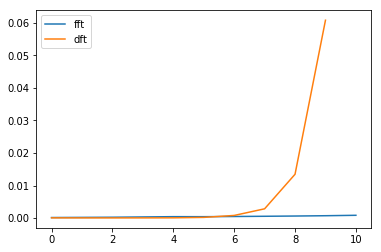

In [450]:
plt.plot(fft_bm[:11], label="fft")
plt.plot(dft_bm[:11], label="dft")
plt.legend()

# Short-time Fourier Transform (2 pts)

    Use torch.hann_window

In [22]:
def STFT(X, window_size, step):
    return FFT(
        X.unfold(
            1, window_size, 
            step
        ) * torch.hann_window(window_size)
    )

In [23]:
window_size = 2048
A = wav[0].unfold(0, window_size, int(window_size/4)) * torch.hann_window(window_size)

In [24]:
A.shape

torch.Size([413, 2048])

In [25]:
wav

tensor([[-0.0025, -0.0037,  0.0005,  ...,  0.0003,  0.0002, -0.0004]])

In [28]:
A_fft = STFT(wav, window_size, int(window_size/4))

In [29]:
A_fft_torch = torch.stft(wav, n_fft=2048, window=torch.hann_window(window_size)).norm(dim=-1)[0].T

In [31]:
np.log(A_fft.T[:int(A_fft.shape[1]/2)] + 10e-6);

In [32]:
def plot_spect(A_fft):
    fig, ax = plt.subplots(figsize=(15, 10))
    im = ax.imshow(
        np.log(A_fft.T), 
        cmap='Blues_r', aspect='auto', vmin=-1, vmax=0, origin='lower'
    )
    fig.colorbar(im, ax=ax)

In [35]:
abs(A_fft[:, :int(A_fft.shape[1]/2)])

tensor([[[0.0238, 0.0312, 0.0262,  ..., 0.0211, 0.0262, 0.0312],
         [0.0028, 0.0353, 0.0323,  ..., 0.0118, 0.0323, 0.0353],
         [0.0303, 0.0135, 0.0349,  ..., 0.0316, 0.0349, 0.0135],
         ...,
         [0.0035, 0.0308, 0.0336,  ..., 0.0265, 0.0336, 0.0308],
         [0.0257, 0.0229, 0.0261,  ..., 0.0040, 0.0261, 0.0229],
         [0.0333, 0.0125, 0.0146,  ..., 0.0400, 0.0146, 0.0124]]])

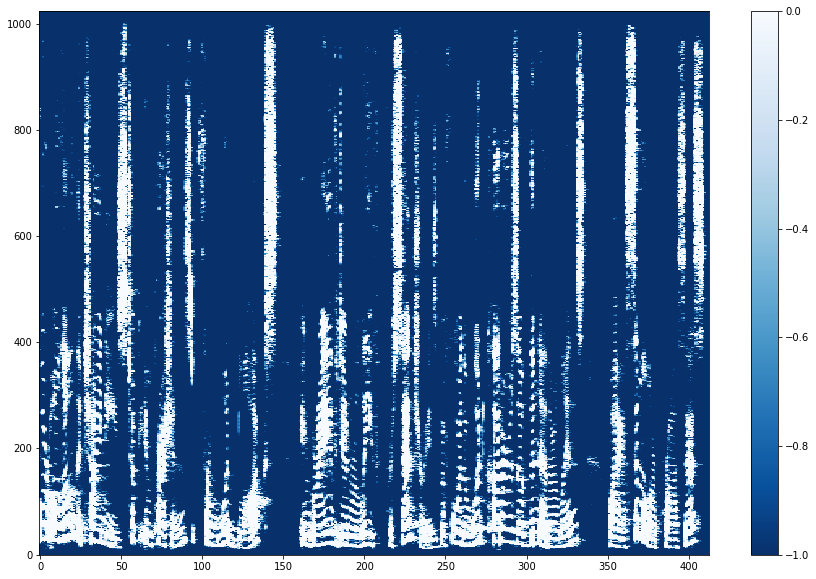

In [39]:
plot_spect(abs(A_fft[0][:, :int(A_fft.shape[2]/2)]))

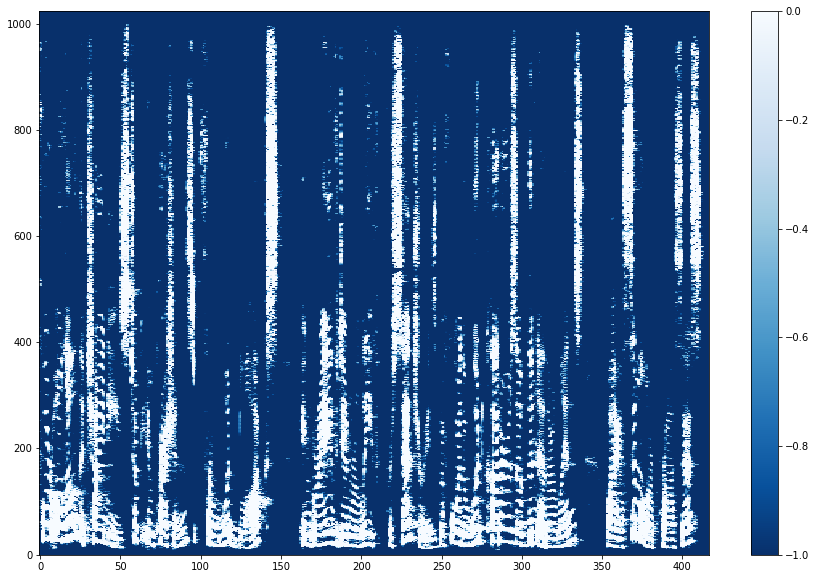

In [40]:
plot_spect(A_fft_torch)

In [41]:
Audio(wav, rate=sr)

# Train Whistle

In [64]:
def plotFileSTFTtorch(file, window_size=1024, step=256):
    w, sr_w = torchaudio.load(file)
    wStft = torch.stft(w, n_fft=window_size, window=torch.hann_window(window_size)).norm(dim=-1)[0].T
    plot_spect(wStft)

In [72]:
def plotFileSTFT(file, window_size=1024, step=256, min_k=0, max_k=512):
    w, sr_w = torchaudio.load(file)
    wStft = STFT(w, window_size, int(window_size/4))
    plot_spect(abs(wStft[0][:, min_k:max_k]))
    plot_spect(np.angle(wStft[0][:, min_k:max_k]))

/Users/nikitakrutoy/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/Users/nikitakrutoy/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


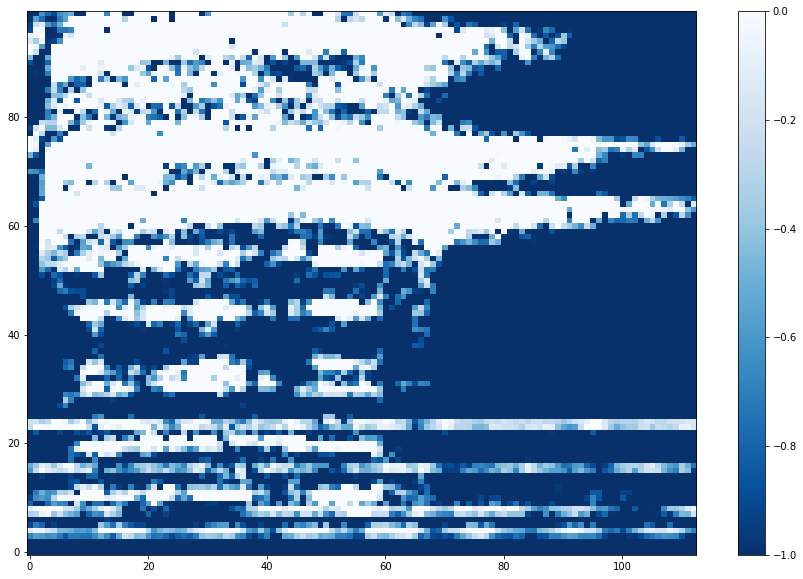

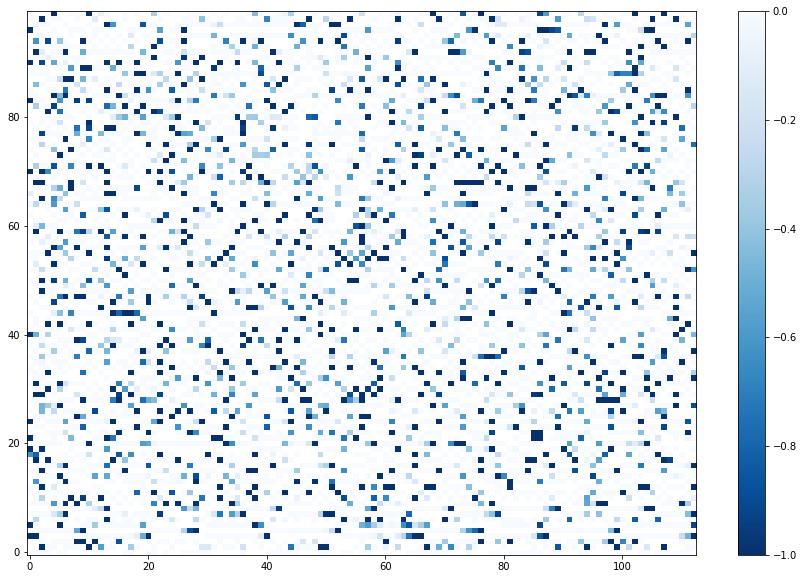

In [73]:
plotFileSTFT('train_whistle.wav', max_k=100)

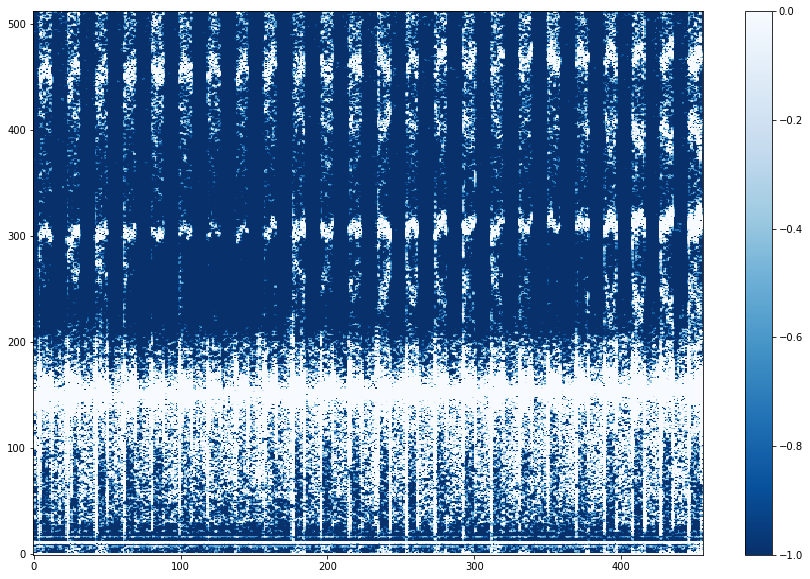

In [66]:
plotFileSTFTtorch('sputnik_1.wav')

/Users/nikitakrutoy/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/Users/nikitakrutoy/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


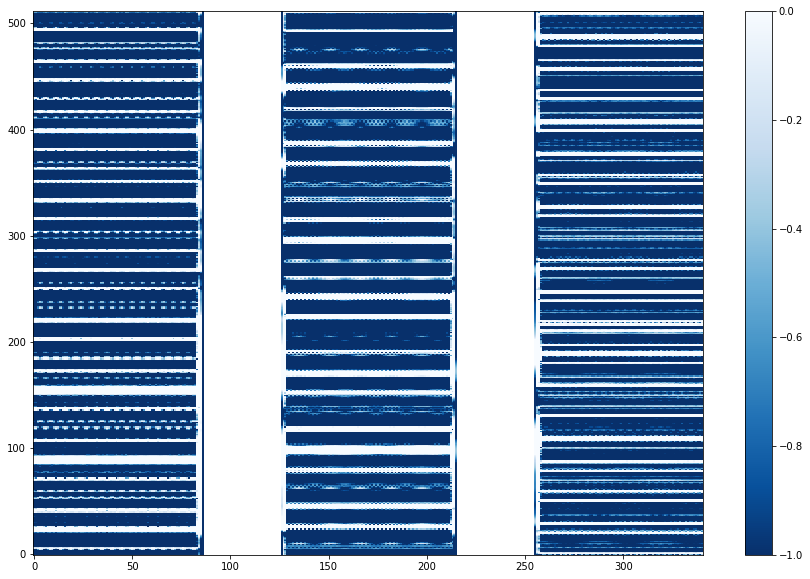

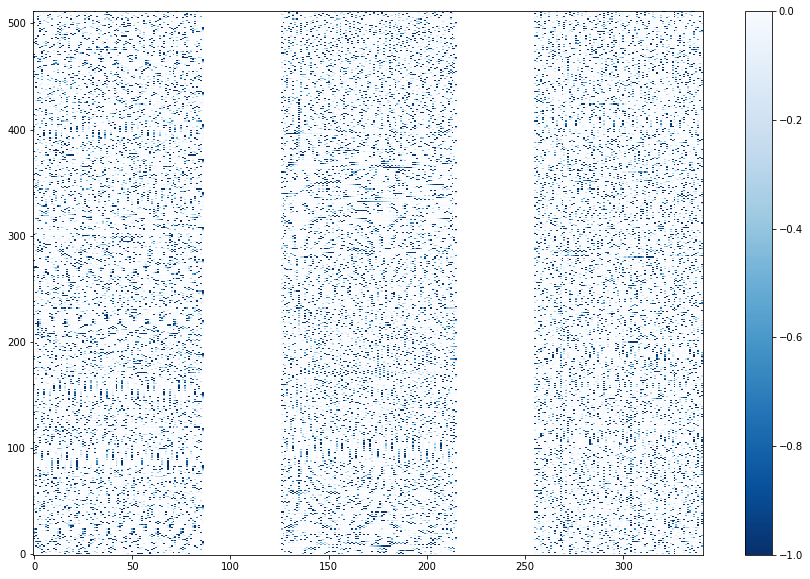

In [58]:
plotFileSTFT('dtmf.wav')

In [74]:
def complexFromAbsAndAngle(absolute, angle):
    a = absolute / (np.tan(angle) + 1)
    b = a*tan(x)
    return a + i*b

In [96]:
w.unsqueeze(0).shape

torch.Size([1, 1, 29814])

In [99]:
file = 'train_whistle.wav'
w, sr_w = torchaudio.load(file)
wFFT = FFT(w[:, :1024 * 8].unsqueeze(0))

In [104]:
a = wFFT.numpy().real
b = wFFT.numpy().imag * 1j

In [105]:
from scipy.fft import ifft

In [112]:
Audio(ifft(a)[0][0], rate=sr_w)

/Users/nikitakrutoy/.pyenv/versions/3.6.6/lib/python3.6/site-packages/IPython/lib/display.py:157: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(data, dtype=float)


In [115]:
ifft(b)[0][0]

array([ 0.        -5.1397365e-08j, -0.00402832+1.9441359e-08j,
        0.07867424+9.3132257e-09j, ..., -0.11920162+3.3608849e-08j,
       -0.07867424+5.1139665e-08j,  0.00402832+1.4042879e-08j],
      dtype=complex64)

In [113]:
Audio(ifft(b)[0][0], rate=sr_w)

# MelScale (2 pts)

[Tap on me](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/)

In [35]:
def mel(f):
    return 1125 * torch.log(torch.tensor(1 + f/700))

def mel_inverse(m): 
    return 700 * (torch.exp(m/1125) - 1)
    

In [36]:
mel(8000)

tensor(2834.9978)

In [37]:
freqs = mel_inverse(torch.linspace(mel(300), mel(8000), steps=10))
indeces = torch.floor(freqs * window_size / sr).type(torch.int)

In [38]:
def build_filter(prev, curr, nxt, N):
    res = np.zeros(N)
    line = np.arange(N)
    res[np.logical_and(line < curr, line >= prev)] = (np.arange(prev, curr) - prev) / (curr - prev)
    res[np.logical_and(line < nxt, line >= curr)] = (nxt - np.arange(curr, nxt)) / (nxt - curr)
    return res

def build_filters(arr, window_size):
    l = [0] + arr + [window_size]
    return [build_filter(l[i-1], l[i], l[i+1], window_size) for i in range(1, len(arr) + 1)]

In [39]:
indeces

tensor([ 27,  53,  85, 126, 177, 243, 327, 434, 570, 743], dtype=torch.int32)

In [40]:
filter_bank = torch.tensor(np.vstack(build_filters(indeces.tolist(), window_size)))

In [268]:
def get_mel_filters(min_freq=300, max_freq=8000, steps=10, window_size=2048, sr=16000):
    freqs = mel_inverse(torch.linspace(mel(min_freq), mel(max_freq), steps=steps))
    indeces = torch.floor(freqs * window_size / sr).type(torch.int)
    return torch.tensor(np.vstack(build_filters(indeces.tolist(), window_size)))

In [41]:
filter_bank.shape

torch.Size([10, 2048])

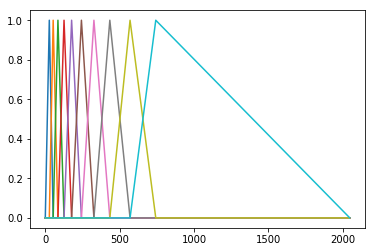

In [42]:
for l in build_filters(indeces.tolist(), window_size):
    plt.plot(l)

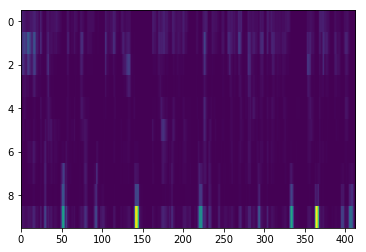

In [43]:
plt.imshow((A_fft @ filter_bank.type(torch.float).T).T, aspect="auto")

# Digit classification (5 pts)

    1) Download data from google drive: https://drive.google.com/file/d/1ouSOru91p-ZJCyI6E8cGh7N0r3vffi06/view?usp=sharing
    
    2) Split data in 80/20 proportion. Please note that both the train and the test
    must contain all types of digits and all speakers, so carefully split the data.
    
    3) The AudioMNIST dataset1 consists of 30000 audio recordings (9.5 hours) 
    of spoken digits (0-9) in English with 50 repetitions per digit for each of the 60 different speakers.
    
    4) Build a classificator of spoken digits. You can use any neural network architecture you like.
        The minimum required quality of classificator will be announced.
    
    5) Each wavfile has the following format: digit_speackerid_wavid.wav
        For example, 6_01_47.wav:
            6 -- the number 6 is spoken
            01 -- the number is spoken by 1 speaker
            47 -- id of wavfile        

    Bonus:
        If you implement a good model or use some augmentation (or something else),
        you can expect to obtain bonuses of up to 3 points.

In [1]:
from os import listdir

In [6]:
a = '59'
a.isdecimal()

True

In [52]:
sr = 16000
seed = 2020

In [ ]:
samples = []
labels = []
tags = []

for speaker_id_str in tqdm(listdir("./AudioMNIST/")):
    if speaker_id_str.isdecimal():
        for audio_filename in tqdm(listdir(f"./AudioMNIST/{speaker_id_str}"), leave=False):
            data, _ = torchaudio.load(f"./AudioMNIST/{speaker_id_str}/{audio_filename}")
            number, speaker = audio_filename.split("_")[:2]
            samples.append(data)
            labels.append(int(number))
            tags.append(f"{number}_{speaker}")

In [51]:
from sklearn.model_selection import StratifiedKFold

In [54]:
skf = StratifiedKFold(n_splits=5, random_state=seed)

In [57]:
train_indeces, test_indeces = next(skf.split(samples, tags))

In [70]:
max_len = max([sample.size()[1] for sample in samples])

In [74]:
samples = [
    torch.cat((sample.flatten(), torch.zeros(max_len - sample.size()[1])))
    for sample in tqdm(samples)
]

In [82]:
samples_stacked = torch.stack(samples, dim=0)

In [192]:
window_size=2048
step=int(window_size / 4)

In [241]:
b_size = 64
res = []
for i in tqdm(range(0, samples_stacked.shape[0], b_size)):
    res.append(
        STFT(samples_stacked[i: i + b_size], window_size=window_size, step=step).abs()
    )
samples_stft = torch.cat(res, dim=0)

In [243]:
samples_stft = samples_stft[:, :, :int(window_size/2)]

In [244]:
samples_stft.shape

torch.Size([30000, 28, 1024])

In [270]:
filter_bank = get_mel_filters(steps=10, window_size=int(window_size/2), sr=sr)

In [271]:
samples_mel = samples_stft @ filter_bank.T.float()

In [272]:
samples_mel.shape

torch.Size([30000, 28, 10])

In [273]:
X = samples_mel.view(samples_mel.shape[0], -1)

In [274]:
y = torch.tensor(labels)

In [453]:
model = torch.nn.Sequential(
    torch.nn.Linear(X.shape[1], 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 10),
)

In [454]:
optimizer = torch.optim.Adam(model.parameters())

In [455]:
from torch.utils.data import TensorDataset, DataLoader

In [456]:
batch_size = 1024 * 16
loader = DataLoader(
    TensorDataset(X[train_indeces], y[train_indeces]),
    batch_size=batch_size
)

In [457]:
X_test, y_test = X[test_indeces], y[test_indeces]

In [471]:
epoch = 0
loss_history_train = []
loss_history_test = []
score_history = []

In [479]:
with torch.autograd.detect_anomaly():
    for epoch in tqdm(range(50)):
        for i, (X_batch, y_batch) in enumerate(loader):
            y_pred = model(X_batch)
            loss = torch.nn.functional.cross_entropy(y_pred, y_batch)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            loss_history_train.append(loss.item())
    #         print("Loss Train",  loss.item())


            if i % 10 == 0:
                y_pred = model(X_test)
                loss = torch.nn.functional.cross_entropy(y_pred, y_test)
                loss_history_test.append(loss.item())
    #             print("Loss Test",  loss.item())
        
    

/Users/nikitakrutoy/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  """Entry point for launching an IPython kernel.


In [480]:
loss

tensor(0.0063, grad_fn=<NllLossBackward>)

In [481]:
import matplotlib.pyplot as plt

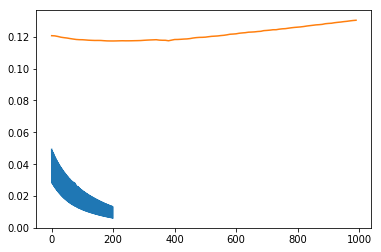

In [484]:
plt.plot(loss_history_train, label="train")
plt.plot((np.arange(len(loss_history_test)) * 10), loss_history_test[-100:], label="test")

In [490]:
from sklearn.metrics import f1_score

In [493]:
y_pred = torch.argmax(model(X_test), dim=1)

In [495]:
f1_score(y_test.numpy(), y_pred.numpy(), average="macro")

0.9876658018956915